# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP1-ML-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).

**Data**
You will have at your disposal the ISIC 2017 dataset (https://challenge.isic-archive.com/data/#2017) already pre-processed, resized and quality checked. It is divided into Training (N=2000), Validation (N=150) and Test (N=600) sets.

**Goal**
The goal of this practical session is to classify images of skin lesions as either benign (nevus or seborrheic_keratosis) or melanoma (binary classification) using machine and deep learning algorithms.

In the first part of the TP, you will manually compute some features relevant to the skin lesion classification (feature engineering) and then classify images using "classical" ML algorithms such as, logistic regression, SVM and Random Forests.

In the second part, you will test the features learnt with Deep Learning algorithms. You will first train from scratch well-known CNN architectures (VGG, ResNet, DenseNet, etc..) and then leverage the representations learnt by these networks on a pre-training from Imagenet (fine-tuning, full-restimation).

Please complete the code where you see **"XXXXXXXXX"** and answer the **Questions**


# Feature Engineering

Many features have been proposed for Skin lesion classification. Among the most used ones, there is the so-called ABCD rule whose features describie four important characteristics of the skin lesion: Asymmetry, Border irregularity, Colour(and Texture) and Dimension (and Geometry).

To compute these features, you will have at your disposal the *manual segmentation* of the skin lesions and you could follow, for instance, *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

Other works can be found in the literature.

For the ML part, you can use the CPU server (no need for GPU here)

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.io import imsave
from skimage.transform import resize
from skimage import color
from skimage import measure
from skimage import transform
from skimage.color import rgb2gray
from scipy import ndimage
from scipy import stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import torch
import glob
import cv2
from PIL import Image


%matplotlib inline

try:
  import google.colab
  IN_COLAB = True
  !pip install gdown==4.6.0 # with the following versions, there is an error
except:
  IN_COLAB = False

You can either download the data from my Google Drive or work locally.

In [2]:
if IN_COLAB:
  print("you are using google colab")
  import gdown
  !mkdir ./data
  gdown.download(id="1iH5hkRN0wCgGklUN5df9u2Ue3UXAR4xZ", output='./data/TrainCropped.zip', quiet=False)
  !unzip -qu "./data/TrainCropped.zip" -d "./data"
  gdown.download(id="1lyRZuV9UST55AEqwSy4mqMmh5yHGI1FM", output='./data/TestCropped.zip', quiet=False)
  !unzip -qu "./data/TestCropped.zip" -d "./data"
  gdown.download(id="1RLJOmqAnHCgiJ7qShQurpxNaRhjjPpJb", output='./data/ValCropped.zip', quiet=False)
  !unzip -qu "./data/ValCropped.zip" -d "./data"
  !rm -rf ./data/TrainCropped.zip
  !rm -rf ./data/TestCropped.zip
  !rm -rf ./data/ValCropped.zip
  path='./data/'
else:
  print('You are NOT using colab')
  # we assume that folders of data are in the same folder as this jupyter notebook
  path='' # if you change this path , you should also change idTRain, idVal and idTest


you are using google colab
mkdir: cannot create directory ‘./data’: File exists


Downloading...
From: https://drive.google.com/uc?id=1iH5hkRN0wCgGklUN5df9u2Ue3UXAR4xZ
To: /content/data/TrainCropped.zip
100%|██████████| 31.6M/31.6M [00:00<00:00, 69.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lyRZuV9UST55AEqwSy4mqMmh5yHGI1FM
To: /content/data/TestCropped.zip
100%|██████████| 10.7M/10.7M [00:00<00:00, 142MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RLJOmqAnHCgiJ7qShQurpxNaRhjjPpJb
To: /content/data/ValCropped.zip
100%|██████████| 2.43M/2.43M [00:00<00:00, 64.3MB/s]


If there is an error (might happen with gdown) please upload the three files manually.
Follow the following instructions:
- go to the folder symbol on the left of your screen
- click on the three vertical dots on the 'data' folder
- upload (importer in french) the three folders
That's it !

In [3]:
# if IN_COLAB:
#   !unzip -qu "./data/TrainCropped.zip" -d "./data"
#   !unzip -qu "./data/TestCropped.zip" -d "./data"
#   !unzip -qu "./data/ValCropped.zip" -d "./data"
#   !rm -rf ./data/TrainCropped.zip
#   !rm -rf ./data/TestCropped.zip
#   !rm -rf ./data/ValCropped.zip
#   path='./data/'

Let's load the data.

In [4]:
pathTrain=glob.glob(path + "TrainCropped/*.jpg")
print(pathTrain)
idTrain=np.copy(pathTrain)
if IN_COLAB:
    for i in np.arange(len(idTrain)): idTrain[i]=idTrain[i][20:-4]
else:
    for i in np.arange(len(idTrain)): idTrain[i]=idTrain[i][13:-4]
#print(idTrain)
print('There are', len(idTrain), 'Train images')

['./data/TrainCropped/ISIC_0013497.jpg', './data/TrainCropped/ISIC_0000148.jpg', './data/TrainCropped/ISIC_0000165.jpg', './data/TrainCropped/ISIC_0010317.jpg', './data/TrainCropped/ISIC_0014571.jpg', './data/TrainCropped/ISIC_0013933.jpg', './data/TrainCropped/ISIC_0010013.jpg', './data/TrainCropped/ISIC_0013656.jpg', './data/TrainCropped/ISIC_0010024.jpg', './data/TrainCropped/ISIC_0014328.jpg', './data/TrainCropped/ISIC_0000190.jpg', './data/TrainCropped/ISIC_0011213.jpg', './data/TrainCropped/ISIC_0010481.jpg', './data/TrainCropped/ISIC_0012911.jpg', './data/TrainCropped/ISIC_0013227.jpg', './data/TrainCropped/ISIC_0012865.jpg', './data/TrainCropped/ISIC_0011382.jpg', './data/TrainCropped/ISIC_0000013.jpg', './data/TrainCropped/ISIC_0014469.jpg', './data/TrainCropped/ISIC_0012785.jpg', './data/TrainCropped/ISIC_0008280.jpg', './data/TrainCropped/ISIC_0012501.jpg', './data/TrainCropped/ISIC_0015110.jpg', './data/TrainCropped/ISIC_0014579.jpg', './data/TrainCropped/ISIC_0010586.jpg',

In [5]:
pathVal=glob.glob(path + "ValCropped/*.jpg")
idVal=np.copy(pathVal)
if IN_COLAB:
    for i in np.arange(len(idVal)): idVal[i]=idVal[i][18:-4]
else:
    for i in np.arange(len(idVal)): idVal[i]=idVal[i][11:-4]
#print(idVal)
print('There are', len(idVal) , 'Validation images')

There are 150 Validation images


In [6]:
pathTest=glob.glob(path + "TestCropped/*.jpg")
idTest=np.copy(pathTest)
if IN_COLAB:
    for i in np.arange(len(idTest)): idTest[i]=idTest[i][19:-4]
else:
    for i in np.arange(len(idTest)): idTest[i]=idTest[i][12:-4]
#print(idTest)
print('There are', len(idTest) , 'Test images')

There are 600 Test images


We can then plot an image with the related mask and contour.

Text(0.5, 1.0, 'Image with mask')

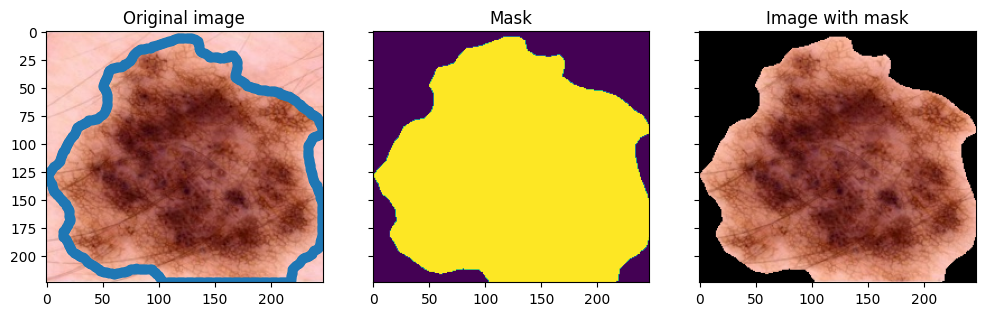

In [7]:
name_im = idTrain[10]
filename = path + 'TrainCropped/{}.jpg'.format(name_im)
image = imread(filename)
filename_Segmentation = path + 'TrainCropped/{}seg.png'.format(name_im)
image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
image_Segmentation_boolean = (image_Segmentation/255).astype(np.uint8) # To get uint16
image_Segmentation_expand = np.expand_dims(image_Segmentation_boolean, axis=2)
image_mul_mask = (image_Segmentation_expand*image)
contours = cv2.findContours(image_Segmentation_boolean, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contour = list(contours[0])
contour = np.squeeze(np.asarray(contour))

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(image)
grid[0].scatter(contour[:,0],contour[:,1])
#grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(image_Segmentation_boolean)
#grid[1].axis('off')
grid[1].set_title("Mask")
grid[2].imshow(image_mul_mask)
#grid[2].axis('off')
grid[2].set_title("Image with mask")

##Manual Feature Engineering

In this part, you will have to manually compute features relevant to the skin lesion classification. You can, for instance, implement the features described in [1] or in other papers.

**TODO**: Implement at least 10 features belonging to at least 3 classes of the ABCD rule, namely:
- Asymmetry
- Border
- Color (and Texture)
- Dimension (and Geometry)

**Please note the overall time (reading papers + implementation + computation) for computing the features. You will need it in the next part of the practical session.**

**This part counts for half of the grade of this TP**

[1] M. Zortea et al. "Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists". Artificial Intelligence in Medicine. 2014

In [8]:
import numpy as np
from skimage import color, io, exposure

# 3 colour features
def colors_full_lesion(image):
  # Converting RGB to CIE L*a*b* color space
  lab_image = color.rgb2lab(image)
  L, a, b = lab_image[:, :, 0], lab_image[:, :, 1], lab_image[:, :, 2]

  # Random selection of 10000 pixels
  random_indices = np.random.choice(L.size, 10000, replace=False)
  sampled_L = L.flatten()[random_indices]
  sampled_a = a.flatten()[random_indices]
  sampled_b = b.flatten()[random_indices]

  # 3D histogram with provided ([1]) bin size and ranges
  hist, edges = np.histogramdd((sampled_L, sampled_a, sampled_b), bins = 2, range=((0, 100), (-127, 127), (-127, 127)))

  # considering non-empty bins for score computation
  non_empty_bins = hist > 0
  non_empty_bin_count = np.sum(non_empty_bins)

  if non_empty_bin_count > 0:
      f1 = np.sum(hist[non_empty_bins]) / non_empty_bin_count
      f2 = np.var(hist[non_empty_bins])
  else:
      f1, f2 = 0, 0
  # Feature: Percentage of non-empty bins in the color space
  f3 = non_empty_bin_count / np.prod(hist.shape)

  return f1, f2, f3

In [9]:
def colors_peripheral_versus_central(image, segmentation_mask):

    contours, _ = cv2.findContours(segmentation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)

    # Initializing the internal border
    internal_border = contour.copy()

    # Iteratively shrinking the internal border
    for _ in range(10):  # The number of iterations can be adjusted
        internal_border = cv2.approxPolyDP(internal_border, 0.95, True)


    # Creating binary masks for  inner and outer regions
    inner_mask = np.zeros_like(segmentation_mask)
    outer_mask = np.zeros_like(segmentation_mask)

    cv2.drawContours(inner_mask, [internal_border], -1, 1, thickness=cv2.FILLED)
    outer_mask = segmentation_mask - inner_mask

    # Extracting pixel values from inner and outer regions
    inner_pixels = image[inner_mask == 1]
    outer_pixels = image[outer_mask == 1]

    # Calculating mean values for L, a, b channels
    if inner_pixels.size > 0:
      inner_mean = np.mean(inner_pixels, axis=0)
    else:
      inner_mean = [0, 0, 0]

    if outer_pixels.size > 0:
      outer_mean = np.mean(outer_pixels, axis=0)
    else:
      outer_mean = [0, 0, 0]

    color_features = outer_mean - inner_mean

    return color_features

In [10]:
from skimage import morphology

# 3 geometric features
def geometric_features(image):
  gray_image = color.rgb2gray(image)
  percentiles = [25, 50, 75]
  threshold_values = np.percentile(gray_image, percentiles)

  features = []
  # Applying morphological opening with a disk element of radius 5 pixels
  disk_element = morphology.disk(5)

  for threshold in threshold_values:
      # Thresholding the gray-scale image
      binary_mask = gray_image > threshold
      # Applying morphological opening
      opened_mask = morphology.binary_opening(binary_mask, footprint = disk_element)
      # Finding connected components to count the number of pieces
      _, labeled_mask = cv2.connectedComponents(np.uint8(opened_mask))
      # Counting the number of pieces (excluding background)
      num_pieces = np.max(labeled_mask)
      features.append(num_pieces)

  return features[0], features[1], features[2]

In [11]:
# Compactness (1 Border feature)
def calculate_compactness(binary_mask):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)

    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)

    compactness = (perimeter ** 2) / (4 * np.pi * area)

    return compactness

Features extracted:

1. Based on colour
- [3 features] colors_full_lesion(image)
- [3 features] colors_peripheral_versus_central(image, segmentation_mask)

2. Based on geometry
- [3 features] geometric_features(image)

3. Based on border
- [1 feature] compactness(segmentation_mask)

In [12]:
from tqdm.notebook import tqdm
import time

def compute_features(dataset, split):
  start_time = time.time()
  features = []

  for i in tqdm(range(0, len(dataset))):
      name_im = dataset[i]
      filename = path + f'{split}Cropped/{name_im}.jpg'
      image = imread(filename)
      filename_Segmentation = path + f'{split}Cropped/{name_im}seg.png'
      image_Segmentation_mask = imread(filename_Segmentation) # Value 0 or 255
      binary_mask = (image_Segmentation_mask/255).astype(np.uint8)

      f1, f2, f3 = colors_full_lesion(image)
      f4, f5, f6 = colors_peripheral_versus_central(image, binary_mask)
      f7, f8, f9 = geometric_features(image)
      f10 = calculate_compactness(binary_mask)

      img_feature = [f1, f2, f3, f4, f5, f6, f7, f8, f9, f10]

      features.append(img_feature)

  end_time = time.time()
  print(f"Time taken: {end_time - start_time:.6f} seconds")

  return np.array(features)

In [13]:
X_train = compute_features(idTrain, "Train")

  0%|          | 0/2000 [00:00<?, ?it/s]

Time taken: 147.375450 seconds


In [14]:
X_val = compute_features(idVal, "Val")

  0%|          | 0/150 [00:00<?, ?it/s]

Time taken: 7.535338 seconds


In [15]:
X_test = compute_features(idTest, "Test")

  0%|          | 0/600 [00:00<?, ?it/s]

Time taken: 29.136035 seconds


In [16]:
X_train.shape, X_val.shape, X_test.shape

((2000, 10), (150, 10), (600, 10))

## Loading Metadata and Target values

You have at your disposal also two metadata, the age and the sex. If you want, you can use them as features in the classification but be careful ! There are missing values

We also load the target values (0 for benign and 1 for melanoma)

In [17]:
Metatrain = pd.read_csv('./data/TrainCropped/ISIC-2017_Training_Data_metadata.csv')
print(Metatrain.head(10))
Groundtrain = pd.read_csv('./data/TrainCropped/ISIC-2017_Training_Part3_GroundTruth.csv')

       image_id age_approximate     sex
0  ISIC_0000000              55  female
1  ISIC_0000001              30  female
2  ISIC_0000002              60  female
3  ISIC_0000003              30    male
4  ISIC_0000004              80    male
5  ISIC_0000006              25  female
6  ISIC_0000007              25  female
7  ISIC_0000008              30  female
8  ISIC_0000009              30  female
9  ISIC_0000010              35  female


In [18]:
Ytrain=np.zeros(len(idTrain))
for i in range(len(idTrain)):
  name=idTrain[i]
  index=Groundtrain["image_id"].str.find(name)
  max_index = index.argmax()
  Ytrain[i]=int(Groundtrain["melanoma"][max_index])

In [19]:
Metaval = pd.read_csv('./data/ValCropped/ISIC-2017_Validation_Data_metadata.csv')
Groundval = pd.read_csv('./data/ValCropped/ISIC-2017_Validation_Part3_GroundTruth.csv')

In [20]:
Yval=np.zeros(len(idVal))
for i in range(len(idVal)):
  name=idVal[i]
  index=Groundval["image_id"].str.find(name)
  max_index = index.argmax()
  Yval[i]=int(Groundval["melanoma"][max_index])

In [21]:
Metatest = pd.read_csv('./data/TestCropped/ISIC-2017_Test_v2_Data_metadata.csv')
Groundtest = pd.read_csv('./data/TestCropped/ISIC-2017_Test_v2_Part3_GroundTruth.csv')

In [22]:
Ytest=np.zeros(len(idTest))
for i in range(len(idTest)):
  name=idTest[i]
  index=Groundtest["image_id"].str.find(name)
  max_index = index.argmax()
  Ytest[i]=int(Groundtest["melanoma"][max_index])

In [23]:
print(X_train.shape, X_val.shape, X_test.shape)
print(Ytrain.shape, Yval.shape, Ytest.shape)

(2000, 10) (150, 10) (600, 10)
(2000,) (150,) (600,)


## Standard Machine Learning Prediction

In this part, you will use standard ML algorithms (such as logistic regression, SVM and Random Forests) on the features you previously computed.
Before starting, you should look at the data and check the proportion of classes.
Two hints:
- in sklearn you can use *class_weight='balanced'* when calling a ML method
- it exists a very interesting library called *imblearn* (e.g., from imblearn.over_sampling import ADASYN)

In [26]:
np.random.seed(seed = 666)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

**Pre-trained features**: for the next part, you can either use your own features or download a pre-computed set of features.

### On manually extracted features

In [27]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score

In [28]:
class_weights = compute_class_weight('balanced', classes=np.unique(Ytrain), y=Ytrain)
class_weights

array([0.61500615, 2.67379679])

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [30]:
LR_model = LogisticRegression(class_weight = {0: class_weights[0], 1: class_weights[1]},
                              max_iter = 1000,
                              n_jobs = -1,
                              random_state = 666)



In [31]:
LR_model = LogisticRegression(class_weight = {0: class_weights[0], 1: class_weights[1]},
                              max_iter = 1000,
                              n_jobs = -1,
                              random_state = 666)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
scorer = make_scorer(f1_score) #scoring metric

grid_search = GridSearchCV(LR_model, param_grid, scoring=scorer, cv=5, verbose = 3)
grid_search.fit(X_train_scaled, Ytrain)

print("Best Hyperparameters:", grid_search.best_params_)
best_LR_model = grid_search.best_estimator_

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...........................C=0.001;, score=0.323 total time=   1.2s
[CV 2/5] END ...........................C=0.001;, score=0.322 total time=   0.5s
[CV 3/5] END ...........................C=0.001;, score=0.344 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.391 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.275 total time=   0.0s
[CV 1/5] END ............................C=0.01;, score=0.353 total time=   0.0s
[CV 2/5] END ............................C=0.01;, score=0.313 total time=   0.0s
[CV 3/5] END ............................C=0.01;, score=0.353 total time=   0.0s
[CV 4/5] END ............................C=0.01;, score=0.390 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=0.252 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.355 total time=   0.0s
[CV 2/5] END .............................C=0.1;,

In [32]:
predictions_val = best_LR_model.predict(X_val_scaled)

print("\nTest Set Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(Yval, predictions_val))
print("\nClassification Report:")
print(classification_report(Yval, predictions_val))
print("Accuracy:", accuracy_score(Yval, predictions_val))
print("F1 Score:", f1_score(Yval, predictions_val))
print("AUC Score:", roc_auc_score(Yval, best_LR_model.predict_proba(X_val_scaled)[:, 1]))


Test Set Metrics:
Confusion Matrix:
[[85 35]
 [11 19]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.71      0.79       120
         1.0       0.35      0.63      0.45        30

    accuracy                           0.69       150
   macro avg       0.62      0.67      0.62       150
weighted avg       0.78      0.69      0.72       150

Accuracy: 0.6933333333333334
F1 Score: 0.4523809523809524
AUC Score: 0.6208333333333333


In [33]:
predictions_test = best_LR_model.predict(X_test_scaled)

print("\nTest Set Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(Ytest, predictions_test))
print("\nClassification Report:")
print(classification_report(Ytest, predictions_test))
print("Accuracy:", accuracy_score(Ytest, predictions_test))
print("F1 Score:", f1_score(Ytest, predictions_test))
print("AUC Score:", roc_auc_score(Ytest, best_LR_model.predict_proba(X_test_scaled)[:, 1]))


Test Set Metrics:
Confusion Matrix:
[[159 324]
 [ 37  80]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.33      0.47       483
         1.0       0.20      0.68      0.31       117

    accuracy                           0.40       600
   macro avg       0.50      0.51      0.39       600
weighted avg       0.69      0.40      0.44       600

Accuracy: 0.3983333333333333
F1 Score: 0.3071017274472169
AUC Score: 0.5112809895418591


### SVM

In [34]:
svm = SVC(class_weight = {0: class_weights[0], 1: class_weights[1]},
          C = 0.1, degree = 2, gamma = 'auto', kernel = 'poly', probability=True)


svm.fit(X_train_scaled, Ytrain)

SVC(C=0.1, class_weight={0: 0.6150061500615006, 1: 2.6737967914438503},
    degree=2, gamma='auto', kernel='poly', probability=True)

In [35]:
predictions_val = svm.predict(X_val_scaled)

print("\nTest Set Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(Yval, predictions_val))
print("\nClassification Report:")
print(classification_report(Yval, predictions_val))
print("Accuracy:", accuracy_score(Yval, predictions_val))
print("F1 Score:", f1_score(Yval, predictions_val))
print("AUC Score:", roc_auc_score(Yval, svm.predict_proba(X_val_scaled)[:, 1]))


Test Set Metrics:
Confusion Matrix:
[[89 31]
 [22  8]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.74      0.77       120
         1.0       0.21      0.27      0.23        30

    accuracy                           0.65       150
   macro avg       0.50      0.50      0.50       150
weighted avg       0.68      0.65      0.66       150

Accuracy: 0.6466666666666666
F1 Score: 0.2318840579710145
AUC Score: 0.5205555555555555


In [36]:
predictions_test = svm.predict(X_test_scaled)

print("\nTest Set Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(Ytest, predictions_test))
print("\nClassification Report:")
print(classification_report(Ytest, predictions_test))
print("Accuracy:", accuracy_score(Ytest, predictions_test))
print("F1 Score:", f1_score(Ytest, predictions_test))
print("AUC Score:", roc_auc_score(Ytest, svm.predict_proba(X_test_scaled)[:, 1]))


Test Set Metrics:
Confusion Matrix:
[[339 144]
 [ 74  43]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.70      0.76       483
         1.0       0.23      0.37      0.28       117

    accuracy                           0.64       600
   macro avg       0.53      0.53      0.52       600
weighted avg       0.71      0.64      0.66       600

Accuracy: 0.6366666666666667
F1 Score: 0.28289473684210525
AUC Score: 0.5644653253348906


### Random Forest

In [37]:
rf_classifier = RandomForestClassifier(class_weight={0: class_weights[0], 1: class_weights[1]})

rf_classifier.fit(X_train_scaled, Ytrain)

RandomForestClassifier(class_weight={0: 0.6150061500615006,
                                     1: 2.6737967914438503})

In [38]:
predictions_val = rf_classifier.predict(X_val_scaled)

print("\nTest Set Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(Yval, predictions_val))
print("\nClassification Report:")
print(classification_report(Yval, predictions_val))
print("Accuracy:", accuracy_score(Yval, predictions_val))
print("F1 Score:", f1_score(Yval, predictions_val))
print("AUC Score:", roc_auc_score(Yval, rf_classifier.predict_proba(X_val_scaled)[:, 1]))


Test Set Metrics:
Confusion Matrix:
[[118   2]
 [ 28   2]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.98      0.89       120
         1.0       0.50      0.07      0.12        30

    accuracy                           0.80       150
   macro avg       0.65      0.53      0.50       150
weighted avg       0.75      0.80      0.73       150

Accuracy: 0.8
F1 Score: 0.11764705882352941
AUC Score: 0.6215277777777779


In [39]:
predictions_test = rf_classifier.predict(X_test_scaled)

print("\nTest Set Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(Ytest, predictions_test))
print("\nClassification Report:")
print(classification_report(Ytest, predictions_test))
print("Accuracy:", accuracy_score(Ytest, predictions_test))
print("F1 Score:", f1_score(Ytest, predictions_test))
print("AUC Score:", roc_auc_score(Ytest, rf_classifier.predict_proba(X_test_scaled)[:, 1]))


Test Set Metrics:
Confusion Matrix:
[[479   4]
 [116   1]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.99      0.89       483
         1.0       0.20      0.01      0.02       117

    accuracy                           0.80       600
   macro avg       0.50      0.50      0.45       600
weighted avg       0.69      0.80      0.72       600

Accuracy: 0.8
F1 Score: 0.01639344262295082
AUC Score: 0.5631116065898674


### On provided pre-computed features

In [40]:
labels=['f1_asym','f2_asym','f5_asym','f6_asym','f7_bord','f8_bord','f9_bord','f10_color','f11_color','f12_color','f13_color','f14_color','f15_color','f16_color','f17_color','f18_color','meanR','stdR','meanG','stdG','meanB','stdB','maxR','maxG','maxB','Area','Ecc','Diam','Ratio','Perim','f21_geom','f22_geom','f23_geom']

In [41]:
!mkdir ./data
gdown.download(id="1ELg93G9jHeJOhCGBZ35HFs3NZr5Inj_j", output='./data/X_train_eng.npy', quiet=False)
train_computation_time=115 # in minute

mkdir: cannot create directory ‘./data’: File exists


Downloading...
From: https://drive.google.com/uc?id=1ELg93G9jHeJOhCGBZ35HFs3NZr5Inj_j
To: /content/data/X_train_eng.npy
100%|██████████| 528k/528k [00:00<00:00, 74.8MB/s]


In [42]:
gdown.download(id="10sr56q1CEro7HPgQjYo0eVniGNA5og5H", output='./data/X_val_eng.npy', quiet=False)
test_computation_time=12 # in minute

Downloading...
From: https://drive.google.com/uc?id=10sr56q1CEro7HPgQjYo0eVniGNA5og5H
To: /content/data/X_val_eng.npy
100%|██████████| 39.7k/39.7k [00:00<00:00, 19.7MB/s]


In [43]:
!mkdir ./data
gdown.download(id="1RbONb3WyG-CGt6SSi124TSXfkiCzb6-D", output='./data/X_test_eng.npy', quiet=False)
test_computation_time=38 # in minute

mkdir: cannot create directory ‘./data’: File exists


Downloading...
From: https://drive.google.com/uc?id=1RbONb3WyG-CGt6SSi124TSXfkiCzb6-D
To: /content/data/X_test_eng.npy
100%|██████████| 159k/159k [00:00<00:00, 60.9MB/s]


In [44]:
Xtrain=np.load('./data/X_train_eng.npy')
Xtest=np.load('./data/X_test_eng.npy')
Xval=np.load('./data/X_val_eng.npy')

N,M=Xtrain.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(Ytrain), np.sum(Ytrain)))

Number of images: 2000; Number of features per image: 33
Number of healthy nevus: 1626.0; Number of melanoma: 374.0


**Question**: An important point in medical imaging is the explicability. Can you find the most important and discriminative features ? If yes, how ? Hint: random forest has a very interesting function...  

Top 10 Important Features:
1. Feature 9: Importance - 0.1646
2. Feature 5: Importance - 0.1435
3. Feature 4: Importance - 0.1382
4. Feature 3: Importance - 0.1310
5. Feature 1: Importance - 0.1304
6. Feature 7: Importance - 0.0846
7. Feature 8: Importance - 0.0800
8. Feature 6: Importance - 0.0583
9. Feature 2: Importance - 0.0362
10. Feature 0: Importance - 0.0332


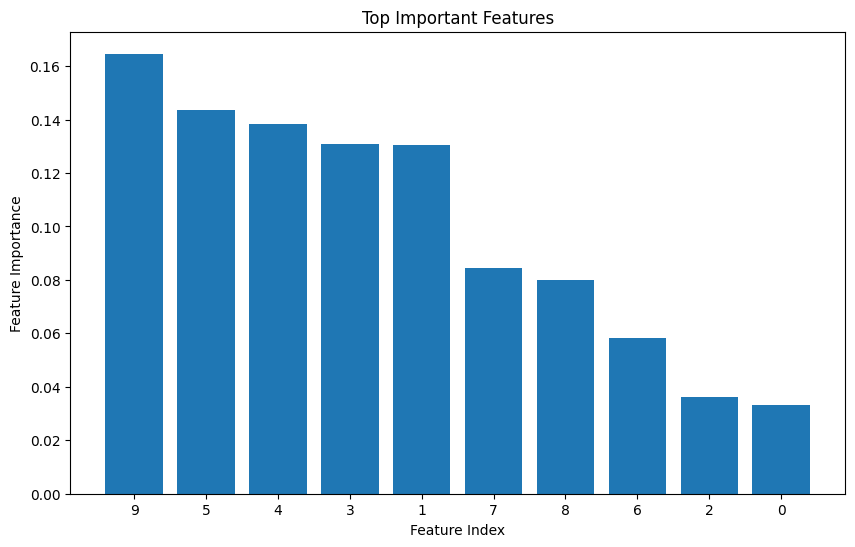

In [45]:
feature_importances = rf_classifier.feature_importances_
sorted_feature_indices = np.argsort(feature_importances)[::-1]

# top N important features
top_n = 10
print("Top", top_n, "Important Features:")
for i in range(top_n):
    print(f"{i + 1}. Feature {sorted_feature_indices[i]}: Importance - {feature_importances[sorted_feature_indices[i]]:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[sorted_feature_indices[:top_n]], align="center")
plt.xticks(range(top_n), sorted_feature_indices[:top_n])
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Top Important Features")
plt.show()

Feature importance on pre-computed features

In [46]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
# Xval_scaled = scaler.transform(Xval)
# Xtest_scaled = scaler.transform(Xtest)


rf_classifier = RandomForestClassifier(class_weight={0: class_weights[0], 1: class_weights[1]})

rf_classifier.fit(Xtrain_scaled, Ytrain)

RandomForestClassifier(class_weight={0: 0.6150061500615006,
                                     1: 2.6737967914438503})

Top 15 Important Features:
1. Feature 29: Importance - 0.0438
2. Feature 26: Importance - 0.0421
3. Feature 3: Importance - 0.0403
4. Feature 20: Importance - 0.0397
5. Feature 15: Importance - 0.0396
6. Feature 14: Importance - 0.0394
7. Feature 28: Importance - 0.0388
8. Feature 12: Importance - 0.0381
9. Feature 21: Importance - 0.0378
10. Feature 10: Importance - 0.0358
11. Feature 17: Importance - 0.0346
12. Feature 13: Importance - 0.0345
13. Feature 2: Importance - 0.0334
14. Feature 11: Importance - 0.0333
15. Feature 7: Importance - 0.0331


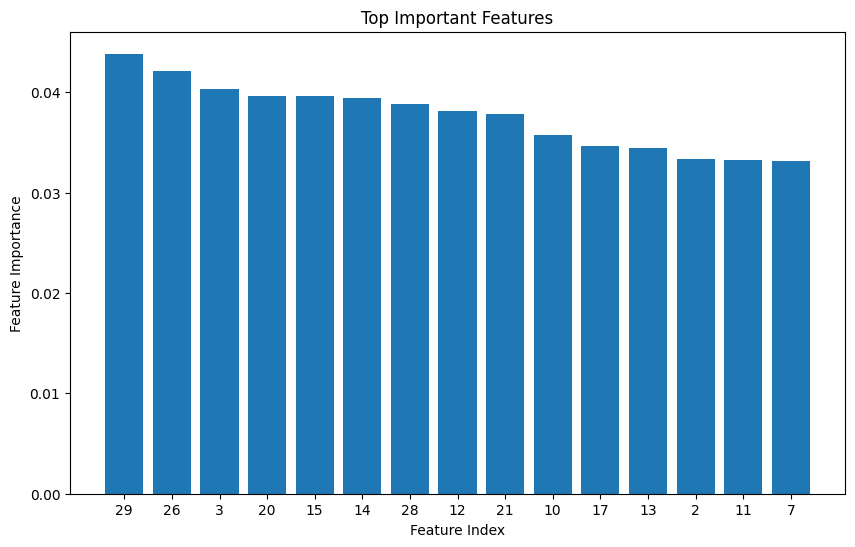

In [47]:
feature_importances = rf_classifier.feature_importances_
sorted_feature_indices = np.argsort(feature_importances)[::-1]

# top N important features
top_n = 15
print("Top", top_n, "Important Features:")
for i in range(top_n):
    print(f"{i + 1}. Feature {sorted_feature_indices[i]}: Importance - {feature_importances[sorted_feature_indices[i]]:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[sorted_feature_indices[:top_n]], align="center")
plt.xticks(range(top_n), sorted_feature_indices[:top_n])
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Top Important Features")
plt.show()

Now you should have a final ML model with a generalization performance on the Test Set.

**Question**: Are you satisfied ? How long did it take to compute and evaluate the manually engineered features ? If you are not satisfied, what are the main problems ? Besides Deep Learning, could you do something to improve the results (if you had more time?)

I am not quite satisfied with the achieved AUC and F1 scores on the test set, but then again, I did not expect very high scores based on the few features that I somehow computed.

Approximate time required
1. To skim through the provided papers = 1.5 hours
2. Compute features = 14 hours
3. Fix bugs and handle exceptions in the feature extractor functions = 2 hours
4. ML models' hyperparameter tuning = 1 hour

Thus, total time spent on this notebook is approximately 17.5 hours.

If more time were available, I could explore further feature engineering techniques majorly, including trying different transformations or interactions between features. From the ML modelling part, I could have tried different ensemble methods.